In [59]:
import os
import re
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np

In [60]:
hyper = np.load("run/heisenberg/hyper_cube_fine.npy")
N = 15
lr = hyper[:, 0].reshape((N,N))
rcond = hyper[:, 1].reshape((N,N))

In [61]:
betas = [0, 0.3, 0.6, 0.9]
rel_errs = []
survival = []

leaders = []

for i, beta in enumerate(betas):
    path = "/mnt/beegfs/workdir/evan.wonisch/NeuralQuantumStates/data/gridsearch_fine/beta="+str(beta)+"/"
    files = os.listdir(path)
    re_flat = np.zeros((N*N,)) - 1
    num = np.zeros((N*N,))

    for file in files:
        index = int(re.split("=|_", file)[2])
        seed = re.split("=|_", file)[4]
        type = re.split("\.|_", file)[-2]

        if type == "summary":
            dat = np.load(path + file)
            final_err = dat[-1]

            if re_flat[index] == -1:        # minimum error
                re_flat[index] = final_err

            if final_err < re_flat[index]:
                re_flat[index] = final_err

            if len(leaders) <= i:            # leader
                leaders.append((beta, index, seed, final_err))
            else:
                if final_err < leaders[i][-1]:
                    leaders[i] = (beta, index, seed, final_err)

            num[int(index)] += 1

    rel_errs.append(re_flat.reshape((N,N)))
    survival.append(num.reshape((N,N))/10)

In [62]:
##
## leaders
##
leaders_data = []
leaders_hyp = []
for beta, index, seed, err in leaders:
    path = "/mnt/beegfs/workdir/evan.wonisch/NeuralQuantumStates/data/gridsearch_fine/beta="+str(beta)+"/"
    rel_errs_time = np.load(path + "hyper_i="+str(index)+"_seed="+str(seed)+"_rel_err.npy")
    hyp = hyper[index]
    leaders_data.append(rel_errs_time)
    leaders_hyp.append(hyp)

/tmp/ipykernel_215365/1372591834.py:24: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  f.colorbar(re_im, cax=cbar_ax)
/tmp/ipykernel_215365/1372591834.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


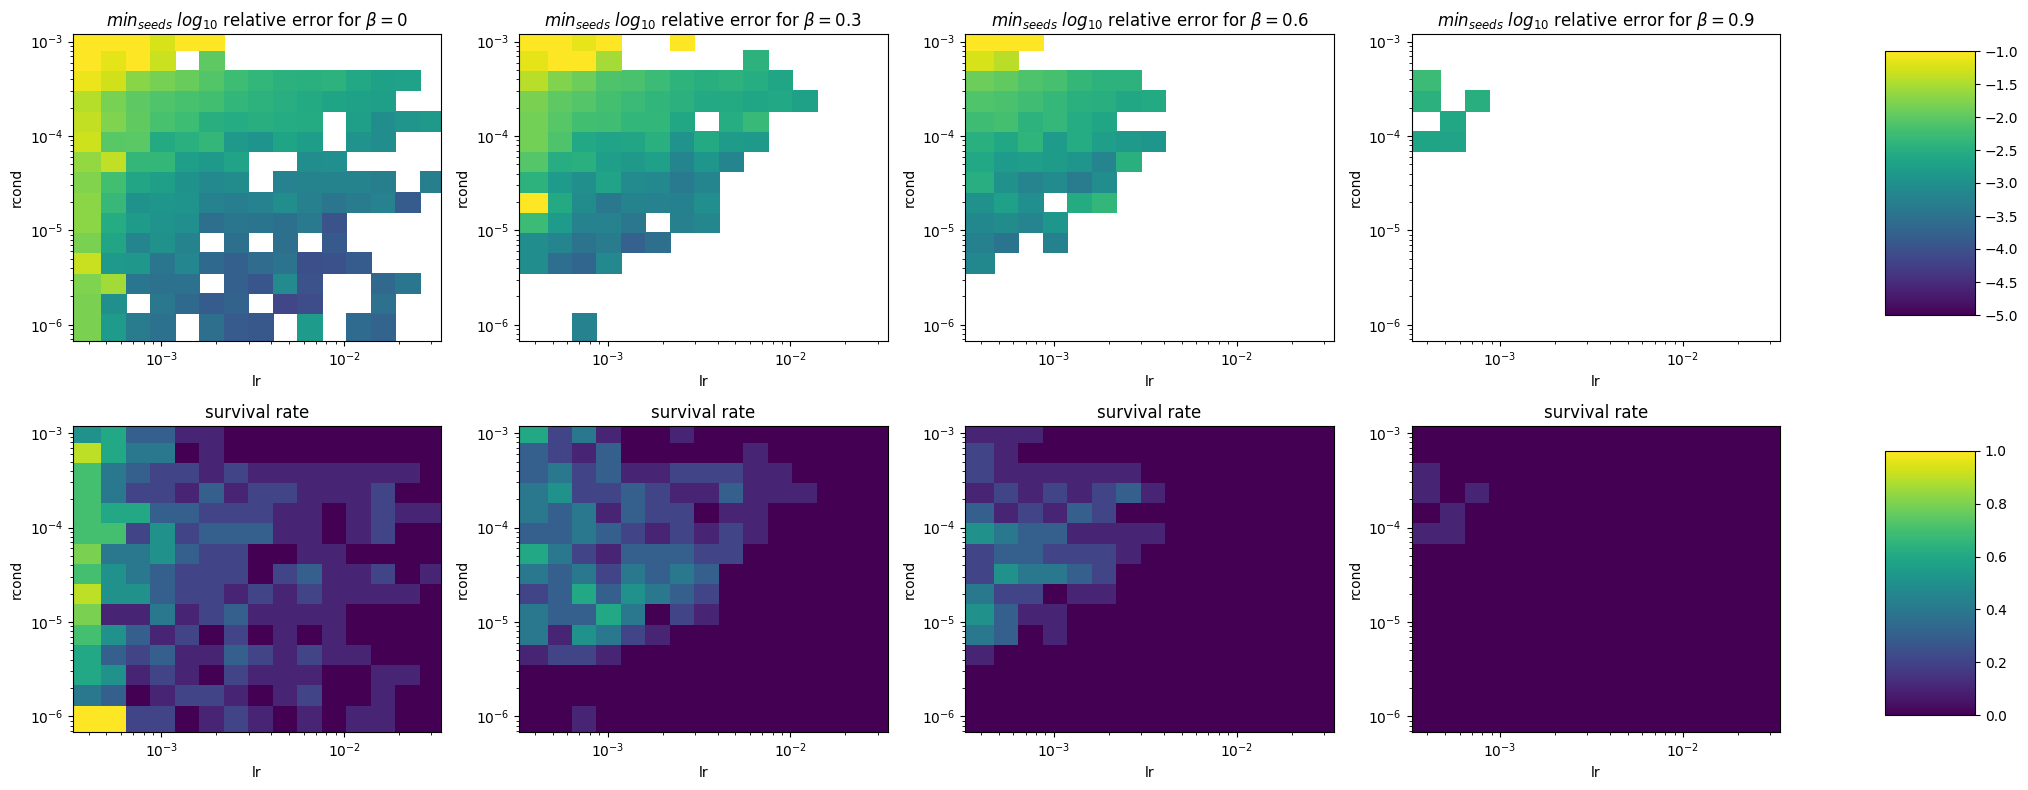

In [64]:
f, axs = plt.subplots(2, len(betas), figsize = (18,8))

re_axes = []
surv_axes = []
for i, beta in enumerate(betas):
    re_im = axs[0, i].pcolor(lr, rcond, jnp.log(rel_errs[i])/jnp.log(10), vmin = -5, vmax = -1)
    axs[0, i].set_ylabel("rcond")
    axs[0, i].set_xlabel("lr")
    axs[0, i].set_title("$min_{seeds}$ $log_{10}$ relative error for $\\beta="+str(beta)+"$")
    axs[0, i].set_xscale("log")
    axs[0, i].set_yscale("log")
    re_axes.append(axs[0,i])

    surv_im = axs[1, i].pcolor(lr, rcond, survival[i], vmin = 0, vmax =1)
    axs[1, i].set_ylabel("rcond")
    axs[1, i].set_xlabel("lr")
    axs[1, i].set_title("survival rate")
    axs[1, i].set_xscale("log")
    axs[1, i].set_yscale("log")
    surv_axes.append(axs[1, i])

# error
cbar_ax = f.add_axes([1.05, 0.6, 0.05, 0.33])
f.colorbar(re_im, cax=cbar_ax)

# survival
cbar_ax = f.add_axes([1.05, 0.1, 0.05, 0.33])
f.colorbar(surv_im, cax=cbar_ax)

f.tight_layout()

## leaders

Text(0.5, 1.0, 'optimisation of runs with lowest error for different beta')

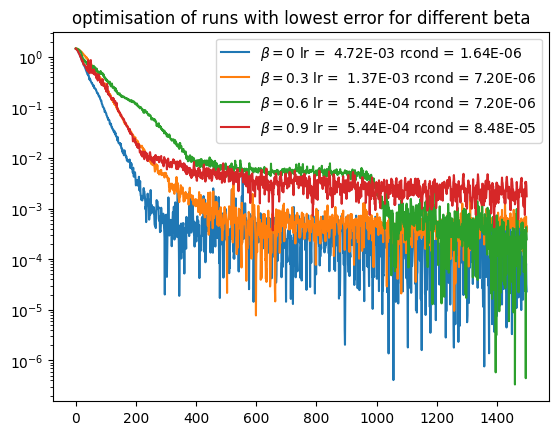

In [65]:
for i, beta in enumerate(betas):
    plt.plot(leaders_data[i], label = "$\\beta = $"+str(beta)+" lr =  "+"{:.2E}".format(leaders_hyp[i][0]) + " rcond = "+"{:.2E}".format(leaders_hyp[i][1]), color = "C"+str(i))

plt.yscale("log")
# plt.xscale("log")
plt.legend()
plt.title("optimisation of runs with lowest error for different beta")

Text(0.5, 1.0, 'all obtained relative errors')

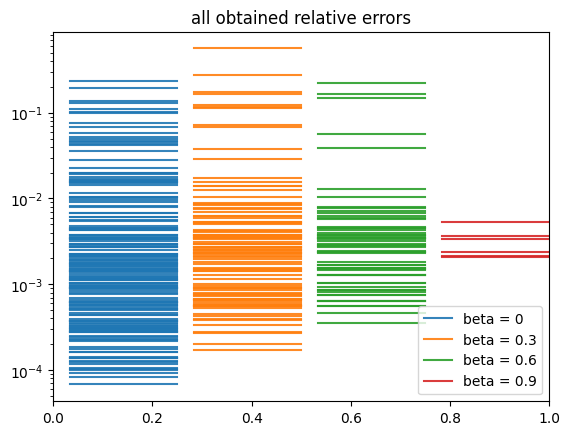

In [66]:
for i, beta in enumerate(betas):
    for j, (err, rate) in enumerate(zip(rel_errs[i].flatten(), survival[i].flatten())):
        if j == 0:
            plt.axhline(err, alpha = 0.9, color = "C"+str(i), xmin = i*0.25+0.033, xmax=(i+1)*0.25, label = "beta = "+str(beta))
        else:
            plt.axhline(err, alpha = 0.9, color = "C"+str(i), xmin = i*0.25+0.033, xmax=(i+1)*0.25)

plt.yscale("log")
plt.legend()
plt.title("all obtained relative errors")